In [1]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)

plt.rcParams['font.size'] = 14
plt.rcParams['font.family'] = 'Arial'

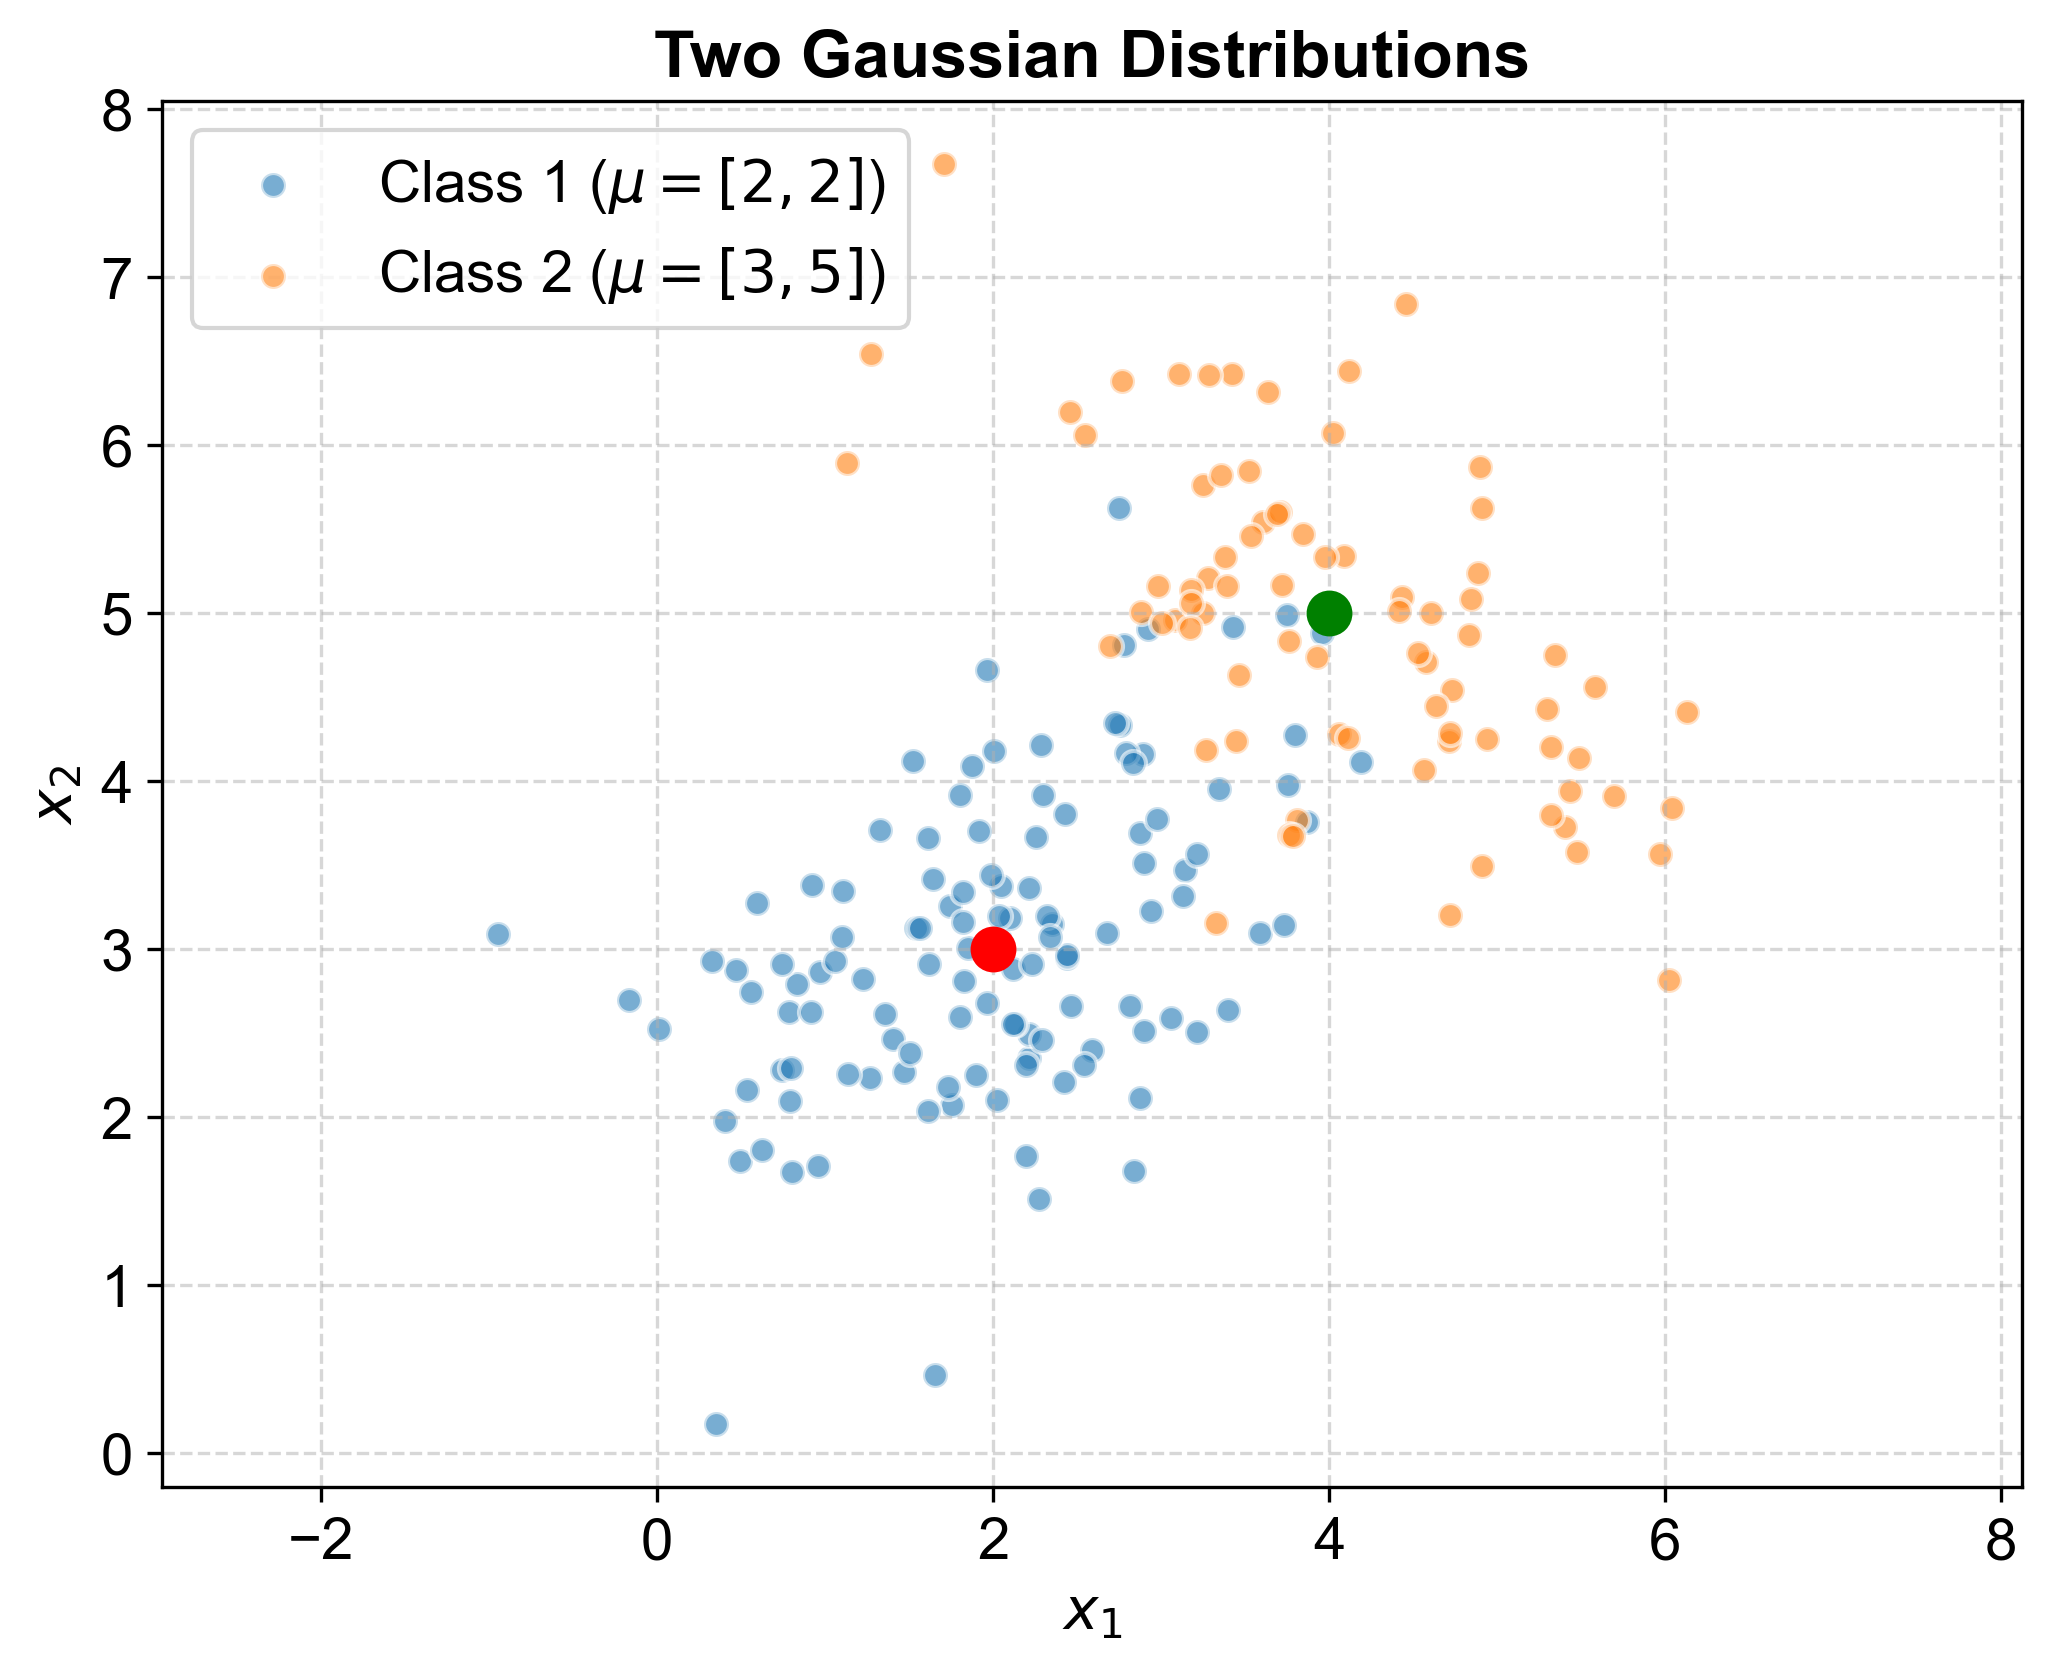

In [17]:
# mu and sigma for two classes
mu1 = [2, 3]
mu2 = [4, 5]

sigma_1 = [[1.0, 0.5],
            [0.5, 1.0]]
sigma_2 = [[1.0, -0.5],
            [-0.5, 1.0]]

# train and test samples
n_samples_1 = 120
n_samples_2 = 80
class1_data_train = np.random.multivariate_normal(mu1, sigma_1, n_samples_1)
class2_data_train = np.random.multivariate_normal(mu2, sigma_2, n_samples_2)

class1_data_test = np.random.multivariate_normal(mu1, sigma_1, n_samples_1*5)
class2_data_test = np.random.multivariate_normal(mu2, sigma_2, n_samples_2*5)

# plot the training data
plt.figure(figsize=(8, 6), dpi=300)

plt.scatter(class1_data_train[:, 0], class1_data_train[:, 1], alpha=0.6, label=fr'Class 1 ($\mu=[2,2]$)', edgecolors='w')
plt.scatter(class2_data_train[:, 0], class2_data_train[:, 1], alpha=0.6, label=fr'Class 2 ($\mu=[3,5]$)', edgecolors='w')

plt.plot(mu1[0], mu1[1], 'ro', markersize=10)
plt.plot(mu2[0], mu2[1], 'go', markersize=10)

plt.title(r'Two Gaussian Distributions', fontsize=16, fontweight='bold')
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.axis('equal')
plt.show()

In [18]:
mu1_est = np.mean(class1_data_train, axis=0)
mu2_est = np.mean(class2_data_train, axis=0)

sigma_1_est = np.cov(class1_data_train, rowvar=False)
sigma_2_est = np.cov(class2_data_train, rowvar=False)

shared_sigma_est = ((class1_data_train.shape[0] - 1) * sigma_1_est + (class2_data_train.shape[0] - 1) * sigma_2_est) / (class1_data_train.shape[0] + class2_data_train.shape[0] - 2)

# Prior probabilities
P_C1 = class1_data_train.shape[0] / (class1_data_train.shape[0] + class2_data_train.shape[0])
P_C2 = class2_data_train.shape[0] / (class1_data_train.shape[0] + class2_data_train.shape[0])

# Bayesian classification functions
def P_x_given_C1(x, mu, sigma):
    size = len(x)
    det = np.linalg.det(sigma)
    norm_const = 1.0 / (np.power((2 * np.pi), size / 2) * np.power(det, 0.5))
    x_mu = x - mu
    inv = np.linalg.inv(sigma)
    result = np.exp(-0.5 * (x_mu @ inv @ x_mu.T))
    return norm_const * result

# Posterior probability P(C1|x) with individual covariances
def P_C1_given_x(x):
    P_x_C1 = P_x_given_C1(x, mu1_est, sigma_1_est)
    P_x_C2 = P_x_given_C1(x, mu2_est, sigma_2_est)
    P_x = P_x_C1 * P_C1 + P_x_C2 * P_C2
    return (P_x_C1 * P_C1) / P_x

# Posterior probability P(C1|x) with shared covariance
def P_C1_given_x_shared(x):
    P_x_C1 = P_x_given_C1(x, mu1_est, shared_sigma_est)
    P_x_C2 = P_x_given_C1(x, mu2_est, shared_sigma_est)
    P_x = P_x_C1 * P_C1 + P_x_C2 * P_C2
    return (P_x_C1 * P_C1) / P_x

x = np.linspace(np.min(class1_data_train[:, 0])-1, np.max(class2_data_train[:, 0])+1, 100)
y = np.linspace(np.min(class1_data_train[:, 1])-1, np.max(class2_data_train[:, 1])+1, 100)
X, Y = np.meshgrid(x, y)

Z_special = np.array([[P_C1_given_x(np.array([X[i, j], Y[i, j]])) for j in range(X.shape[1])] for i in range(X.shape[0])])
Z_shared = np.array([[P_C1_given_x_shared(np.array([X[i, j], Y[i, j]])) for j in range(X.shape[1])] for i in range(X.shape[0])])

In [19]:
# calculate accuracy
def classify(x, use_shared_covariance=False):
    if use_shared_covariance:
        prob_C1 = P_C1_given_x_shared(x)
    else:
        prob_C1 = P_C1_given_x(x)
    return 1 if prob_C1 >= 0.5 else 2

def compute_accuracy(data_class1, data_class2, use_shared_covariance=False):
    correct = 0
    total = data_class1.shape[0] + data_class2.shape[0]
    
    for x in data_class1:
        if classify(x, use_shared_covariance) == 1:
            correct += 1
            
    for x in data_class2:
        if classify(x, use_shared_covariance) == 2:
            correct += 1
            
    return correct / total

accuracy_class_specific = compute_accuracy(class1_data_test, class2_data_test, use_shared_covariance=False)
accuracy_shared = compute_accuracy(class1_data_test, class2_data_test, use_shared_covariance=True)

print(f'Accuracy with Class-Specific Covariance: {accuracy_class_specific * 100:.2f}%')
print(f'Accuracy with Shared Covariance: {accuracy_shared * 100:.2f}%')

Accuracy with Class-Specific Covariance: 93.50%
Accuracy with Shared Covariance: 92.70%


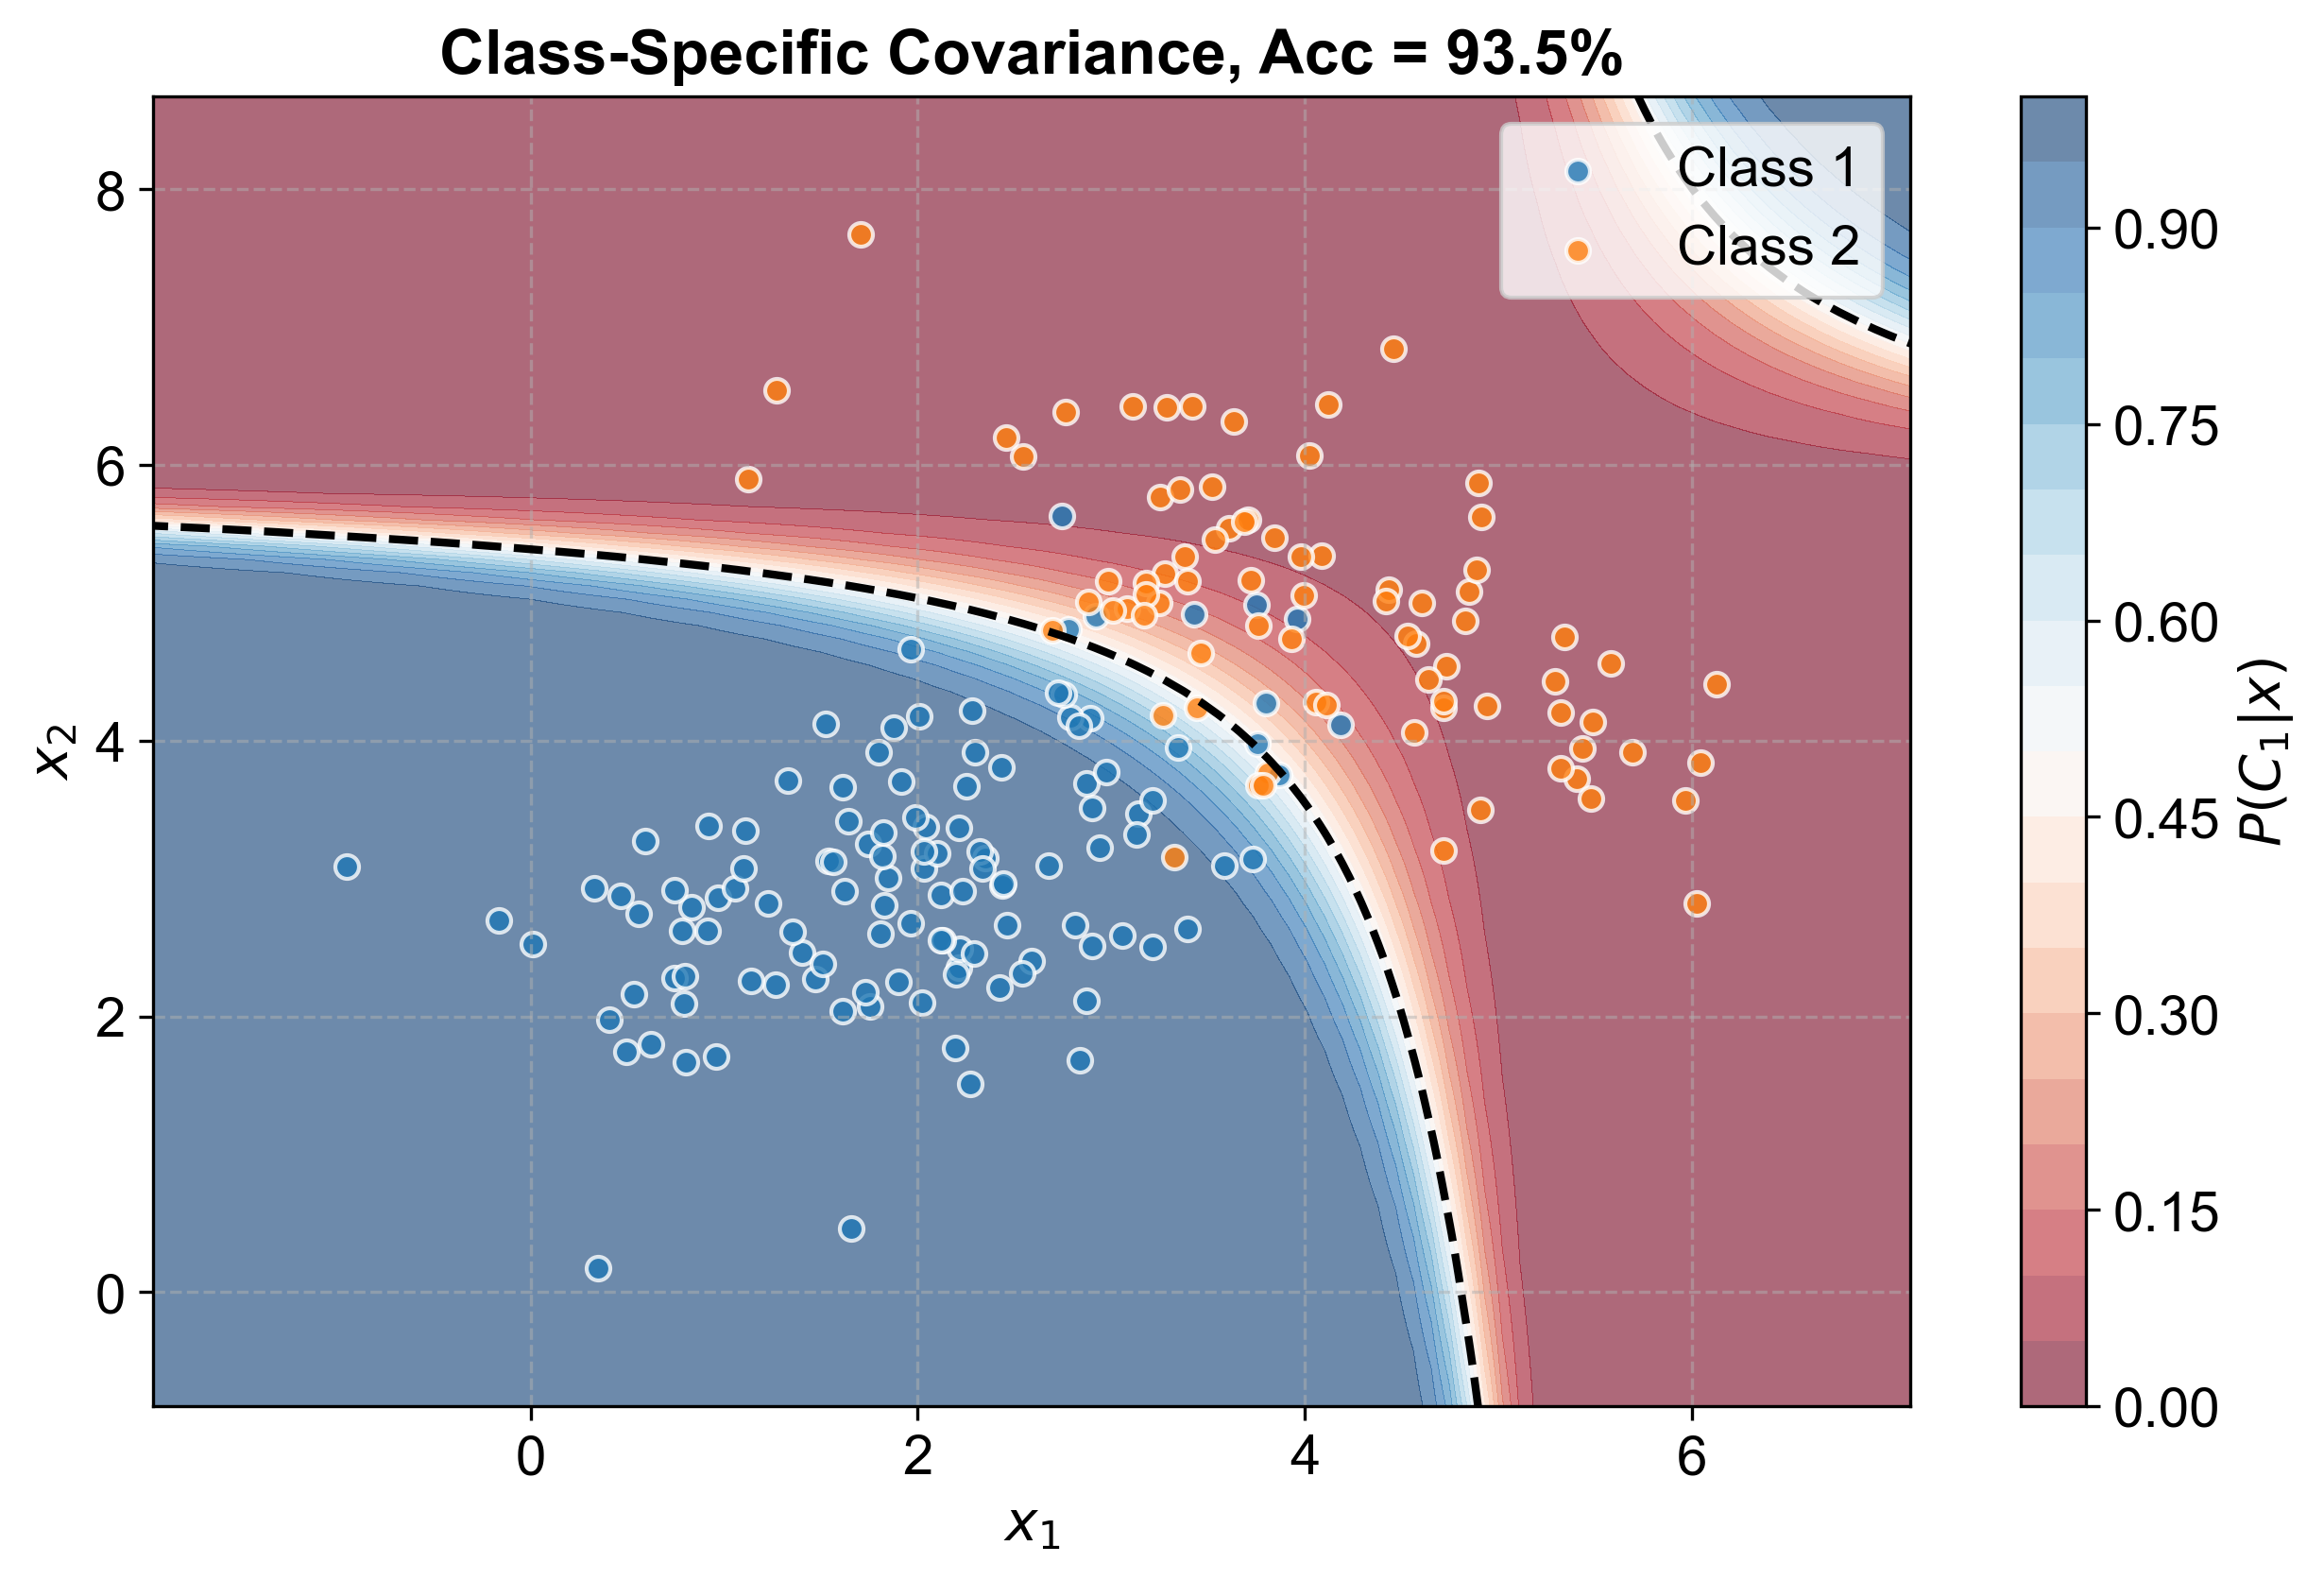

In [21]:
fig, ax = plt.subplots(figsize=(10, 6), dpi=300)
cs = ax.contourf(X, Y, Z_special, levels=20, cmap='RdBu', alpha=0.6)
fig.colorbar(cs, ax=ax, label=r'$P(C_1|x)$')
ax.contour(X, Y, Z_special, levels=[0.5], colors='k', linewidths=2, linestyles='--')
ax.scatter(class1_data_train[:, 0], class1_data_train[:, 1], alpha=0.8, label='Class 1', edgecolors='w')
ax.scatter(class2_data_train[:, 0], class2_data_train[:, 1], alpha=0.8, label='Class 2', edgecolors='w')
ax.set_title(f'Class-Specific Covariance, Acc = {accuracy_class_specific :.1%}', fontweight='bold', fontsize=16)
ax.set_xlabel(r'$x_1$')
ax.set_ylabel(r'$x_2$')
ax.legend()
ax.grid(True, linestyle='--', alpha=0.5)
plt.show()

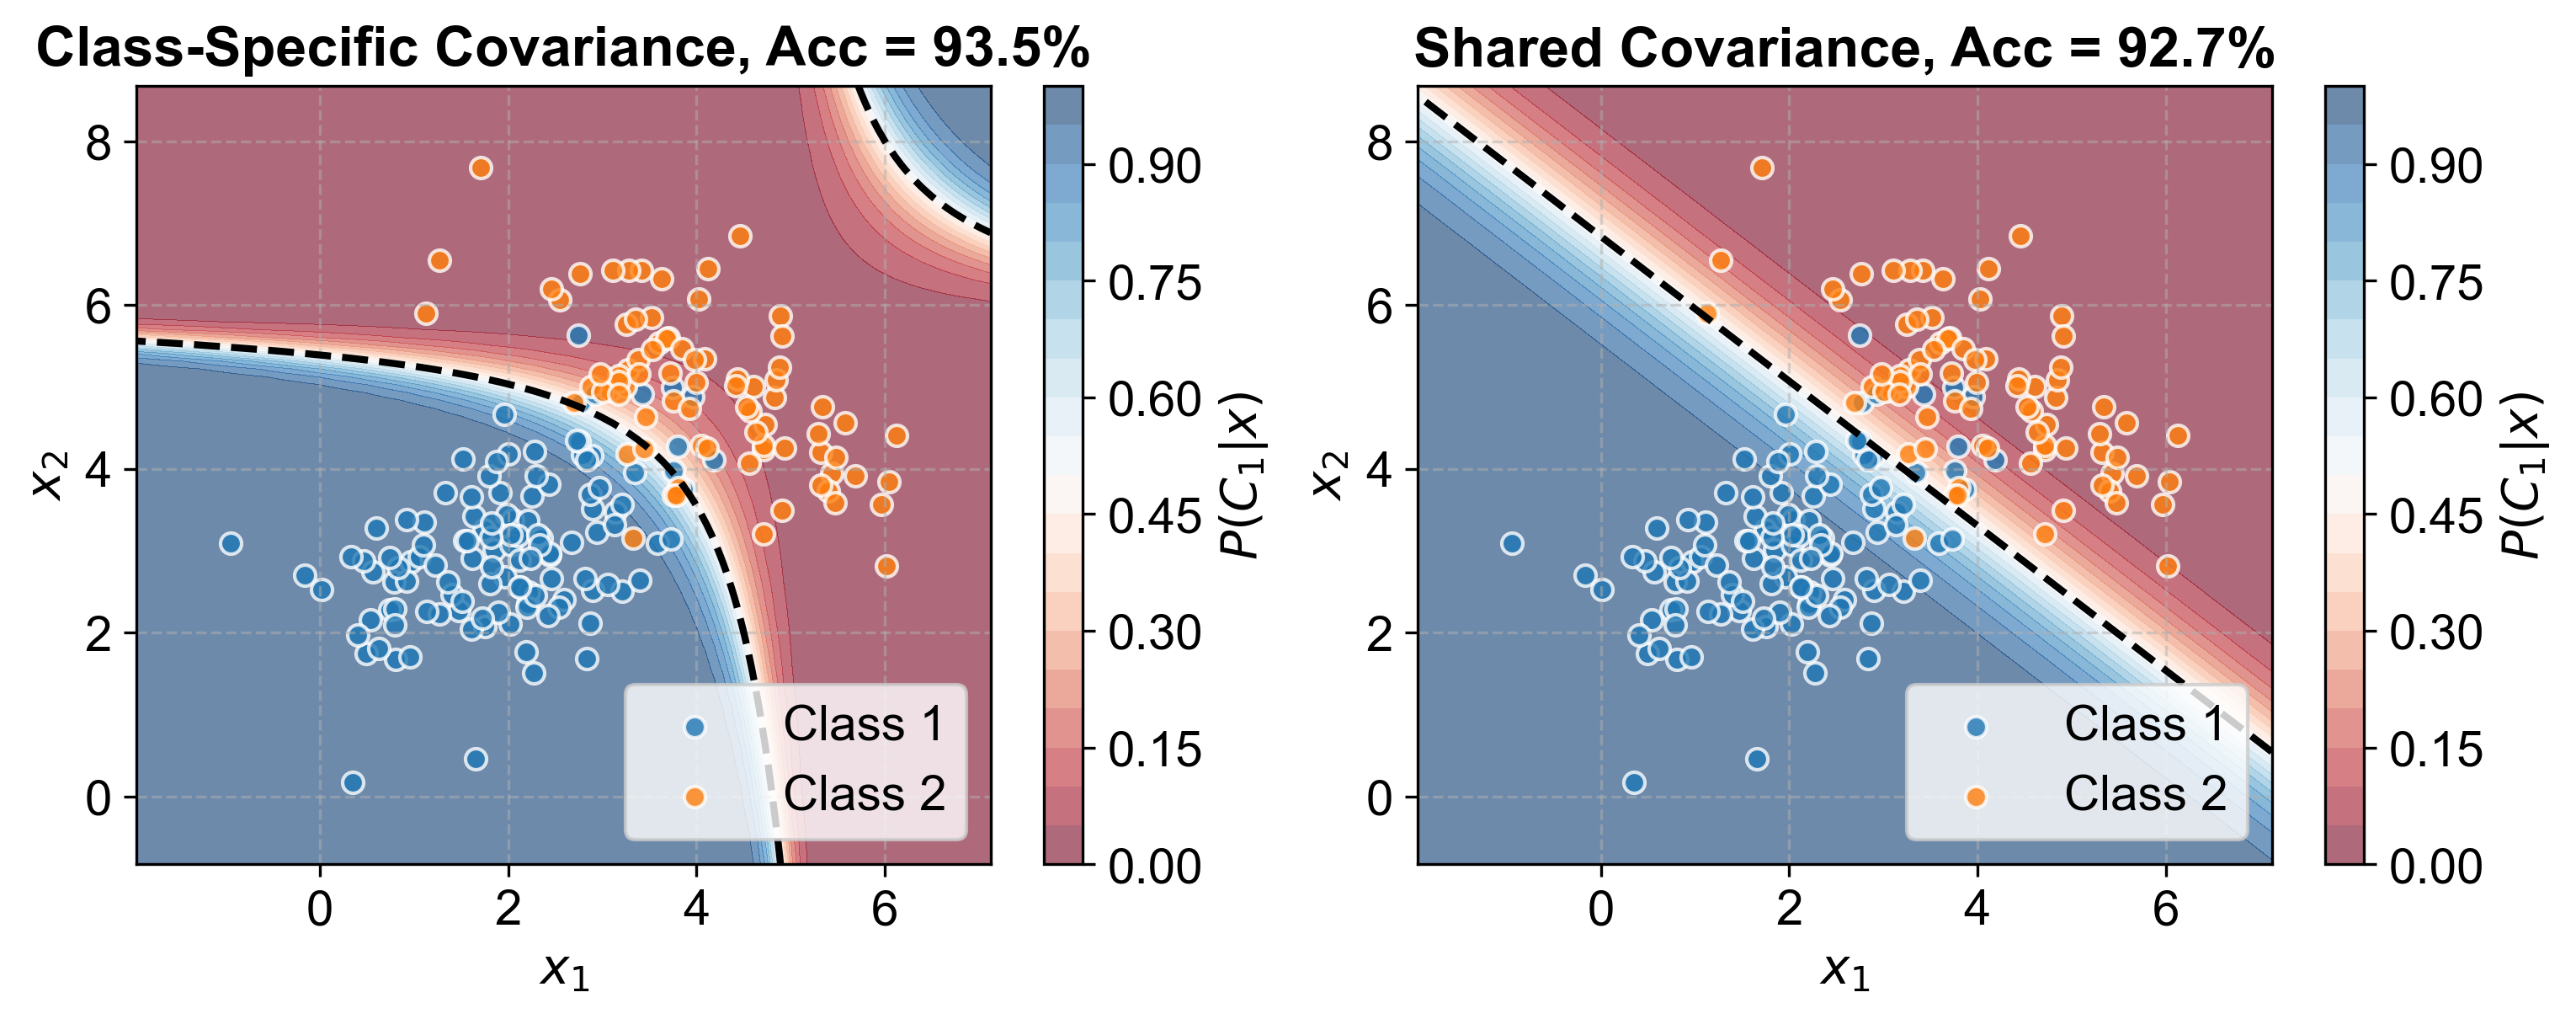

In [24]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4), dpi=300)
cs = ax[0].contourf(X, Y, Z_special, levels=20, cmap='RdBu', alpha=0.6)
fig.colorbar(cs, ax=ax[0], label=r'$P(C_1|x)$')
ax[0].contour(X, Y, Z_special, levels=[0.5], colors='k', linewidths=2, linestyles='--')
ax[0].scatter(class1_data_train[:, 0], class1_data_train[:, 1], alpha=0.8, label='Class 1', edgecolors='w')
ax[0].scatter(class2_data_train[:, 0], class2_data_train[:, 1], alpha=0.8, label='Class 2', edgecolors='w')
ax[0].set_title(f'Class-Specific Covariance, Acc = {accuracy_class_specific :.1%}', fontweight='bold', fontsize=16)
ax[0].set_xlabel(r'$x_1$')
ax[0].set_ylabel(r'$x_2$')
ax[0].legend()
ax[0].grid(True, linestyle='--', alpha=0.5)

cs1 = ax[1].contourf(X, Y, Z_shared, levels=20, cmap='RdBu', alpha=0.6)
fig.colorbar(cs1, ax=ax[1], label=r'$P(C_1|x)$')
ax[1].contour(X, Y, Z_shared, levels=[0.5], colors='k', linewidths=2, linestyles='--')
ax[1].scatter(class1_data_train[:, 0], class1_data_train[:, 1], alpha=0.8, label='Class 1', edgecolors='w')
ax[1].scatter(class2_data_train[:, 0], class2_data_train[:, 1], alpha=0.8, label='Class 2', edgecolors='w')
ax[1].set_title(f'Shared Covariance, Acc = {accuracy_shared :.1%}', fontweight='bold', fontsize=16)
ax[1].set_xlabel(r'$x_1$')
ax[1].set_ylabel(r'$x_2$')
ax[1].legend()
ax[1].grid(True, linestyle='--', alpha=0.5)
plt.show()
